# Prepartion of the work

In [1]:
%pylab nbagg

Populating the interactive namespace from numpy and matplotlib


In [49]:
source = "/scratch/jerome/TimeLapses/2018-06-26-Neron/"
import glob
images = glob.glob(source+"*.jpg")
images.sort()
print(len(images))

823


In [3]:
import numpy
import json
from PIL import Image
import scipy.ndimage
import pyopencl, os
os.environ["PYOPENCL_COMPILER_OUTPUT"]="1" 
import pyopencl.array as gpuarray
from pyopencl.reduction import ReductionKernel
sRGB0 = raw = numpy.asarray(Image.open(images[29]))
sRGB1 = numpy.asarray(Image.open(images[30]))
shape = raw.shape
print(raw.shape, raw.dtype)

(3264, 4928, 3) uint8


# OpenCL code for faster processing

In [4]:
ctx = pyopencl.create_some_context(answers=["0"])#, "0"])
print(ctx)
queue = pyopencl.CommandQueue(ctx, properties = pyopencl.command_queue_properties.PROFILING_ENABLE)

<pyopencl.Context at 0x55fa6023e320 on <pyopencl.Device 'GeForce GTX 750 Ti' on 'NVIDIA CUDA' at 0x55fa603473e0>>


In [5]:
%load_ext pyopencl.ipython_ext

In [43]:
%%cl_kernel

kernel void mean2std(global float* value,
                     global float2* mean,
                     global float* delta2,
                     int size)
{
    int gid = get_global_id(0);
    if (gid>=size)
    {
       return;
    }
    float m = mean[0].s0/mean[0].s1;
    float delta = value[gid] - m;
    delta2[gid] = delta*delta;
}

kernel void sigmaclip(global float* value,
                       global float2* mean,
                       global float2* std,
                       float cutof,                 
                       int size)
{
    int gid = get_global_id(0);
    if (gid>=size)
    {
       return; 
    }
       
    float m = mean[0].s0/mean[0].s1;
    float s = sqrt(std[0].s0/(std[0].s1-1.0f));
    if (fabs(value[gid]-m)>(cutof*s))
    {
        value[gid] = NAN;
    }
}

static float dec_sRGB(uchar value)
{
    float res, a=0.055f, gamma=2.4f,slope=12.92f; 
    if (value<=10)
        res = (float)value/255.0/slope;
    else
        res = pow(((float)value/255.0f + a)/(1.0f+a), gamma);
    return res;
}

static uchar comp_sRGB(float value)
{
    float a=0.055f, gamma=2.4f,slope=12.92f, c=0.0031308f; 
    float res;
    if (value<=c)
        res = value*slope;
    else
        res = (1.0f+a) * powr(value, 1.0f/gamma) - a;
    if (res<0.0f)
        res = 0.0f;
    else if (res>1.0f)
        res = 255.0f;
    else
        res = 255.0f*res + 0.5f;
    
    return (uchar) res;
}

static float comp_L(float value)
{ //https://fr.wikipedia.org/wiki/CIE_L*a*b*

    float epsilon = 216.0f/24389.0f,
          kappa = 24389.0f/27.0f,
          res;
    if (value>epsilon)
        res = pow(value, 1.0f/3.0f);
    else
        res = (kappa * value + 16.0f)/ 116.0f;
    return res;
}

static float dec_L(float value)
{
    float d = 6.0f/29.0f, res;
    if (value>d)
        res = pown(value, 3);
    else
        res = (value - 4.0f/29.0f) * 3.0f * d * d;
    return res;
}

static float3 XYZ2Lab(float3 XYZ)
{
    float3 Lab, 
           D65 = (float3)(0.9504f,  1.0000f, 1.0888f),
           xyz = XYZ/D65,
           fxyz = (float3)(comp_L(xyz.x), comp_L(xyz.y), comp_L(xyz.z));
    Lab = (float3)(116.0f * fxyz.y - 16.0f,
                   500*(fxyz.x - fxyz.y),
                   200*(fxyz.y - fxyz.z));
    return Lab;
}

static float3 Lab2XYZ(float3 Lab)
{
    float3 D65 = (float3)(0.9504f,  1.0000f, 1.0888f),
           xyz;
    float l;
           
    l = (Lab.x + 16.0f)/116.0f;
    xyz = (float3)(dec_L(l + Lab.y/500.0f),
                   dec_L(l),
                   dec_L(l - Lab.z/200.0f));
    return xyz * D65;
}

static float3 RGB2XYZ(float3 RGB)
{
    //const float matrix[9] = {0.4124f, 0.3576f, 0.1805f, 0.2126f, 0.7152f, 0.0722f, 0.0193f, 0.1192f, 0.9505f};
    const float3 to_X = (float3)(0.4124f, 0.3576f, 0.1805f);
    const float3 to_Y = (float3)(0.2126f, 0.7152f, 0.0722f);
    const float3 to_Z = (float3)(0.0193f, 0.1192f, 0.9505f);
    return (float3)(dot(RGB, to_X), dot(RGB, to_Y), dot(RGB, to_Z));
}

static float3 XYZ2RGB(float3 XYZ)
{
    //const float matrix[9] = {3.2410f, -1.5374f, -0.4986f, -0.9692f,  1.8760f,  0.0416f, 0.0556f, -0.2040f,  1.0570f};
    const float3 to_R = (float3)( 3.2410f,-1.5374f,-0.4986f),
                 to_G = (float3)(-0.9692f, 1.8760f, 0.0416f),
                 to_B = (float3)( 0.0556f,-0.2040f,1.0570f);
    return (float3)(dot(XYZ, to_R), dot(XYZ, to_G), dot(XYZ, to_B));
}


kernel void decompress_sRGB(global uchar *sRGB, global float *RGB, int width, int height)
{
    if ((get_global_id(0)<width) && (get_global_id(1) < height))
    {
        int i = 3*(get_global_id(0) + width * get_global_id(1));
        RGB[i] = dec_sRGB(sRGB[i]);
        RGB[i+1] = dec_sRGB(sRGB[i+1]);
        RGB[i+2] = dec_sRGB(sRGB[i+2]);
    }
}

kernel void compress_sRGB(global float *RGB, global uchar *sRGB, int width, int height)
{
    if ((get_global_id(0)<width) && (get_global_id(1) < height))
    {
        int i = 3*(get_global_id(0) + width * get_global_id(1));
        RGB[i] = comp_sRGB(sRGB[i]);
        RGB[i+1] = comp_sRGB(sRGB[i+1]);
        RGB[i+2] = comp_sRGB(sRGB[i+2]);
    }
}

kernel void sRGB_to_Lab(global uchar *sRGB, global float *Lab, int width, int height)
{
    if ((get_global_id(0)<width) && (get_global_id(1) < height))
    {
        float3 RGB, XYZ, LAB;

        int i = 3*(get_global_id(0) + width * get_global_id(1));
        RGB = (float3)(dec_sRGB(sRGB[i]),
                       dec_sRGB(sRGB[i+1]),
                       dec_sRGB(sRGB[i+2]));
        XYZ = RGB2XYZ(RGB);
        LAB = XYZ2Lab(XYZ);
        Lab[i] = LAB.x;
        Lab[i+1] = LAB.y;
        Lab[i+2] = LAB.z;
    }
}

kernel void Lab_to_sRGB(global float *Lab, global uchar *sRGB, int width, int height)
{
    if ((get_global_id(0)<width) && (get_global_id(1) < height))
    {
        float3 RGB, XYZ, LAB;

        int i = 3*(get_global_id(0) + width * get_global_id(1));
        LAB = (float3)(Lab[i], Lab[i+1], Lab[i+2]);
        XYZ = Lab2XYZ(LAB);
        RGB = XYZ2RGB(XYZ);
        sRGB[i] = comp_sRGB(RGB.x);
        sRGB[i+1] = comp_sRGB(RGB.y);
        sRGB[i+2] = comp_sRGB(RGB.z);
    }
}


kernel void convert_color(global float *RGB, global float *XYZ, int width, int height, global float *matrix)
{
    if ((get_global_id(0)<width) && (get_global_id(1) < height))
    {
        int i = get_global_id(0) + width * get_global_id(1);
        XYZ[3*i+0] = RGB[3*i]*matrix[0] + RGB[3*i+1]*matrix[1] + RGB[3*i+2]*matrix[2];
        XYZ[3*i+1] = RGB[3*i]*matrix[3] + RGB[3*i+1]*matrix[4] + RGB[3*i+2]*matrix[5];
        XYZ[3*i+2] = RGB[3*i]*matrix[6] + RGB[3*i+1]*matrix[7] + RGB[3*i+2]*matrix[8];
    }
}

kernel void sRGB_to_RGB(global uchar *sRGB, global float *RGB, int width, int height)
{
    if ((get_global_id(0)<width) && (get_global_id(1) < height))
    {
        float3 RGB3;

        int i = 3*(get_global_id(0) + width * get_global_id(1));
        RGB3 = (float3)(dec_sRGB(sRGB[i]),
                       dec_sRGB(sRGB[i+1]),
                       dec_sRGB(sRGB[i+2]));
        RGB[i] = RGB3.x;
        RGB[i+1] = RGB3.y;
        RGB[i+2] = RGB3.z;
    }
}

// load a float3 from a given prosition:
static float3 load3(global float* image,
                    int index)
{
    float3 res = (float3)(image[3*index], image[3*index+1], image[3*index+2]);
    return res;
}

//Perform a bilinear interpolation of image with 3 channels
static float3 bilinear3(float2 target, 
                        global float* image,
                        int2 size,
                        float3 fill,
                        int mode) //mode = 1 bilinear or 0 for nearest
{
    int tx_prev = (int) target.x,
        tx_next = tx_prev + 1,
        ty_prev = (int) target.y,
        ty_next = ty_prev + 1;

    float3 interp = fill;

    if (0.0f <= target.x && target.x < (size.x - 1) && 0.0f <= target.y && target.y < (size.y - 1) )
    {
        if (mode == 1) 
        {   //bilinear interpolation: read 4 neighbours
            float3 image_p = load3(image, ty_prev*size.x + tx_prev),
                   image_x = load3(image, ty_prev*size.x + tx_next),
                   image_y = load3(image, ty_next*size.x + tx_prev),
                   image_n = load3(image, ty_next*size.x + tx_next);

            if (tx_next >= size.x) 
            {
                image_x = image_p;
                image_n = image_y;
            }
            if (ty_next >= size.y) {
                image_y = image_p;
                image_n = image_x;
            }

            //bilinear interpolation
            float3 interp1 = ((float) (tx_next - target.x)) * image_p + ((float) (target.x - tx_prev)) * image_x,
                   interp2 = ((float) (tx_next - target.x)) * image_y + ((float) (target.x - tx_prev)) * image_n;

            interp = ((float) (ty_next - target.y)) * interp1 + ((float) (target.y - ty_prev)) * interp2;

        }
        else 
        { //no interpolation TODO: round index !
                interp = load3(image, (int)(target.y + 0.5) * size.x + (int)(target.x + 0.5));
        }
    }
    
    //to be coherent with scipy.ndimage.interpolation.affine_transform
    if (target.x >= (size.x - 1)) 
        interp = fill;
    if (target.y >= (size.y - 1)) 
            interp = fill;
    return interp;
}

static float _lanczos_n(float value, float order)
{
    float res=0.0f;
    if (value == 0)
        res = 1.0f;
    else if (fabs(value)>=order)
        res = 0.0f;
    else
        res = order*sin(M_PI_F*value)*sin(M_PI_F*value/order)/(M_PI_F*M_PI_F*value*value);
    return res;
}

//Perform a lanczos interpolation of image with 3 channels, mode may be 
static float3 lanczos(float2 target, 
                      global float* image,
                      int2 size,
                      float2 scale, 
                      float3 fill,
                      int mode) //mode = 1, 2 or 3 for width of the filter
{
    if ((target.x < 0)||target.x > (size.x - 1)||(target.y < 0)||target.y > (size.y - 1))
    {
        return fill;
    }
        
    float4 sum4 = (float4)(0.0f, 0.0f, 0.0f, 0.0f);
    float coef_x, coef_y, coef, fmode=(float) mode;
    int xmin, xmax, ymin, ymax, x, y, idx;
    xmin = max((int)floor(target.x - scale.x * fmode), 0);
    xmax = min((int) ceil(target.x + scale.x * fmode) + 1, size.x);
    ymin = max((int)floor(target.y - scale.y * fmode), 0);
    ymax = min((int) ceil(target.y + scale.y * fmode) + 1, size.y);
    
    for (y=ymin; y<ymax; y++)
    {
        coef_y = _lanczos_n(((float)y-target.y)/scale.y, fmode);
        for (x=xmin; x<xmax; x++)    
        {
            coef_x = _lanczos_n(((float)x-target.x)/scale.x, fmode);
            idx = y * size.x + x;
            coef = coef_x * coef_y;
            if (fabs(coef)>1e-30)
            {
                sum4 += (float4)(load3(image, idx) * coef, coef);
            }
            
        }
    }
    return (float3)(sum4.s0/sum4.s3, sum4.s1/sum4.s3, sum4.s2/sum4.s3);
}

kernel void rotate_image(global float *inp, global float *out, int width, int height, float angle)
{
    if ((get_global_id(0)<width) && (get_global_id(1) < height))
    {
        float cx = width/2.0f, cy = height/2.0f, xout, yout;
        xout = (float) get_global_id(0);
        yout = (float) get_global_id(1);
        
        float2 target = (float2)(cos(angle)*(xout - cx) + sin(angle)*(yout - cy) + cx,
                                -sin(angle)*(xout - cx) + cos(angle)*(yout - cy) + cy);
        int i = get_global_id(0) + width * get_global_id(1);
        float3 out3= bilinear3(target, 
                               inp,
                               (int2)(width, height),
                               (float3) (0.0f,0.0f,0.0f),
                               1);
        out[3*i] = out3.x;
        out[3*i+1] = out3.y;
        out[3*i+2] = out3.z;
    }
}

kernel void unwrap_image(global float *inp, global float *out, 
                         int width_dis, int height_dis,
                         int width_cor, int height_cor,
                         float center_dis_x, float center_dis_y,
                         float center_cor_x, float center_cor_y,
                         float k1, float k2, float k3)
{
    if ((get_global_id(0)<width_cor) && (get_global_id(1) < height_cor))
    {
        float xcor, ycor, r2, correction;
        xcor = (float) get_global_id(0) - center_cor_x;
        ycor = (float) get_global_id(1) - center_cor_y;
        r2 = xcor*xcor + ycor*ycor;
        //K1 = arg[8]*1e-9
        //K2 = arg[9]*1e-15
        //K3 = arg[10]*1e-23
        //return c + (u - c)*
        correction = (1.0f + k1*r2 + k2*r2*r2 + k3*r2*r2*r2);
        float2 target = (float2)(center_dis_x + xcor*correction,
                                 center_dis_y + ycor*correction);
        int i = get_global_id(0) + width_cor * get_global_id(1);
        float3 out3= bilinear3(target, 
                               inp,
                               (int2)(width_dis, height_dis),
                               (float3) (0.0f,0.0f,0.0f),
                               1);
        out[3*i] = out3.x;
        out[3*i+1] = out3.y;
        out[3*i+2] = out3.z;
    }
}

kernel void unwrap_rot_image(global float *inp, global float *out, 
                         int width_dis, int height_dis,
                         int width_cor, int height_cor,
                         float center_dis_x, float center_dis_y,
                         float center_cor_x, float center_cor_y,
                         float k1, float k2, float k3, float angle, 
                         float fill)
{
    if ((get_global_id(0)<width_cor) && (get_global_id(1) < height_cor))
    {
        float xcor, ycor, r2, correction, xcorr, ycorr;
        xcor = (float) get_global_id(0) - center_cor_x;
        ycor = (float) get_global_id(1) - center_cor_y;
        r2 = xcor*xcor + ycor*ycor;
        correction = (1.0f + k1*r2 + k2*r2*r2 + k3*r2*r2*r2);
        xcorr = cos(angle) * xcor - sin(angle) * ycor;
        ycorr = sin(angle) * xcor + cos(angle) * ycor;
        float2 target = (float2)(center_dis_x + xcorr*correction,
                                 center_dis_y + ycorr*correction);
        int i = get_global_id(0) + width_cor * get_global_id(1);
        float3 out3= bilinear3(target, 
                               inp,
                               (int2)(width_dis, height_dis),
                               (float3) (fill, fill, fill),
                               1);
        out[3*i] = out3.x;
        out[3*i+1] = out3.y;
        out[3*i+2] = out3.z;
    }
}

kernel void decimate(global float *inp, global float *out, 
                      int width_inp, int height_inp,
                      int width_out, int height_out,
                      float offset_x, float offset_y,
                      float decimation_x, float decimation_y,
                      int mode, float fill)
{
    if ((get_global_id(0)<width_out) && (get_global_id(1) < height_out))
    {
        float xin, yin;
        float3 out3;
        xin = (float) get_global_id(0) * decimation_x + offset_x;
        yin = (float) get_global_id(1) * decimation_y + offset_y;
        float2 target = (float2)(xin, yin);
        int i = get_global_id(0) + width_out * get_global_id(1);
        
        if (mode<2)
            out3 = bilinear3(target, 
                             inp,
                             (int2)(width_inp, height_inp),
                             (float3) (fill, fill, fill),
                             mode);
        else
            out3 = lanczos(target, 
                           inp,
                           (int2)(width_inp, height_inp),
                           (float2)(decimation_x, decimation_y), 
                           (float3) (fill, fill, fill),
                           mode);
        out[3*i] = out3.x;
        out[3*i+1] = out3.y;
        out[3*i+2] = out3.z;
    }
}

kernel void sinc(global float* data, float scale, float order)
{
    int center = (get_global_size(0) - 1)/2;
    int pos = get_global_id(0) - center;
    data[get_global_id(0)] = _lanczos_n((float)pos/scale, order);

}

kernel void normalize_LAB(global float *LAB, int width, int height, float normalization)
{
    if ((get_global_id(0)<width) && (get_global_id(1) < height))
    {
        int i = 3*(get_global_id(0) + width * get_global_id(1));
        LAB[i] /= normalization;
        LAB[i+1] /= normalization;
        LAB[i+2] /= normalization;
    }
}

kernel void delta_LAB(global float *LAB1,
                      global float *LAB2,
                      global float *delta,
                      int width, int height)
{
    if ((get_global_id(0)<width) && (get_global_id(1) < height))
    {
        int i = 3*(get_global_id(0) + width * get_global_id(1));
        delta[i/3] = LAB2[i] - LAB1[i];
    }
}

kernel void LAB_2_Lum(global float *LAB,
                       global float *gray,
                       int width, int height)
{
    if ((get_global_id(0)<width) && (get_global_id(1) < height))
    {
        int i = (get_global_id(0) + width * get_global_id(1));
        gray[i] = LAB[3*i];
    }
}
kernel void offset_LAB(global float *LAB,
                       float order0,
                       float order1,
                       int width, int height)
{
    if ((get_global_id(0)<width) && (get_global_id(1) < height))
    {
        int i = 3*(get_global_id(0) + width * get_global_id(1));
        LAB[i] = LAB[i]*order1 + order0;
        //#LAB[i] -=delta;
    }
}

kernel void linreg_stage1(global float *Lum1,
                          global float *Lum2,
                          global float4 *sum_xyn,
                          global float4 *VAR,
                          int width, int height)
{
    if ((get_global_id(0)<width) && (get_global_id(1) < height))
    {
        int i = get_global_id(0) + width * get_global_id(1);
        float mean_x = sum_xyn[0].s0 / sum_xyn[0].s2;
        float mean_y = sum_xyn[0].s1 / sum_xyn[0].s2;
        float delta1 = Lum1[i] - mean_x;
        float delta2 = Lum2[i] - mean_y;
        VAR[i] = (float4)(delta1*delta1, delta2*delta2, delta1*delta2, 0.0f);   
    }
}

kernel void linreg_stage2(global float *Lum1,
                          global float *Lum2,
                          global float4 *sum_xyn,
                          global float4 *sum_var,
                          global float *err_sq,
                          int width, int height)
{
    if ((get_global_id(0)<width) && (get_global_id(1) < height))
    {
        int i = get_global_id(0) + width * get_global_id(1);
        float mean_x = sum_xyn[0].s0 / sum_xyn[0].s2;
        float mean_y = sum_xyn[0].s1 / sum_xyn[0].s2;
        
        float s2x = sum_var[0].s0 / sum_var[0].s3;
        //float s2y = sum_var[0].s1 / sum_var[0].s3;
        float sxy = sum_var[0].s2 / sum_var[0].s3;
        float slope = sxy/s2x;
        float intercept = mean_y - slope * mean_x;
        
        float err = intercept + slope*Lum1[i] - Lum2[i];
        err_sq[i] =  err*err;
    }
}
kernel void linreg_clip(global float* Lum1,
                        global float* Lum2,
                        global float4 *sum_xyn,
                        global float4 *sum_var,
                        global float2* sum_err2,
                        float cutof,          
                        global char* mask,
                        int width, int height)
{
    if ((get_global_id(0)<width) && (get_global_id(1) < height))
    {       
        int i = get_global_id(0) + width * get_global_id(1);
        float x = Lum1[i];
        float y = Lum2[i];
        
        float mean_x = sum_xyn[0].s0 / sum_xyn[0].s2;
        float mean_y = sum_xyn[0].s1 / sum_xyn[0].s2;
        
        float s2x = sum_var[0].s0 / sum_var[0].s3;
        float sxy = sum_var[0].s2 / sum_var[0].s3;
        float slope = sxy/s2x;
        float intercept = mean_y - slope * mean_x;
        
        float variance = sum_err2[0].s0/(sum_err2[0].s1-2.0f);
        float error = intercept+slope*x-y;
        
        if ((error*error)>(cutof*cutof*variance))
        {
            mask[i] = 1;
        }
    }
}


In [7]:
srgb0_d  = gpuarray.empty(queue, shape, raw.dtype)
srgb1_d  = gpuarray.empty(queue, shape, raw.dtype)
srgb2_d  = gpuarray.empty(queue, shape, raw.dtype)
rgb_d  = gpuarray.empty(queue, shape, "float32")
xyz_d  = gpuarray.empty(queue, shape, "float32")
lab0_d  = gpuarray.empty(queue, shape, "float32")
lab1_d  = gpuarray.empty(queue, shape, "float32")
grey0_d  = gpuarray.empty(queue, shape[:2], "float32")
grey1_d = gpuarray.empty(queue, shape[:2], "float32")
srgb0_d.set(sRGB0)
srgb1_d.set(sRGB1)
#print(srgb_d)
e1 = decompress_sRGB(queue, (sRGB0.shape[1], sRGB0.shape[0]), None, 
                     srgb0_d.data, rgb_d.data, numpy.int32(sRGB0.shape[1]), numpy.int32(sRGB0.shape[0]))
e1.wait()
#RGB2XYZ_d  = gpuarray.empty(queue, 9, "float32")
#XYZ2RGB_d  = gpuarray.empty(queue, 9, "float32")
#RGB2XYZ_d.set(numpy.array([0.4124, 0.3576, 0.1805, 0.2126, 0.7152, 0.0722, 0.0193, 0.1192, 0.9505], "float32"))
#XYZ2RGB_d.set(numpy.array([3.2410, -1.5374, -0.4986, -0.9692,  1.8760,  0.0416,0.0556, -0.2040,  1.0570], "float32"))
#e2=prg.convert_color(queue, (sRGB.shape[1], sRGB.shape[0]), None, 
#                 rgb_d.data, xyz_d.data, numpy.int32(sRGB.shape[1]), numpy.int32(sRGB.shape[0]), RGB2XYZ_d.data)
#e2.wait()

#e3=prg.convert_color(queue, (sRGB.shape[1], sRGB.shape[0]), None, 
#                 xyz_d.data, rgb_d.data, numpy.int32(sRGB.shape[1]), numpy.int32(sRGB.shape[0]), XYZ2RGB_d.data)
#e3.wait()
#e4=prg.compress_sRGB(queue, (sRGB.shape[1], sRGB.shape[0]), None, 
#                     rgb_d.data, srgb_d.data, numpy.int32(sRGB.shape[1]), numpy.int32(sRGB.shape[0]))
#e4.wait()
#srgb_d
print(abs(srgb0_d.get()-raw.astype(int)).max())
print(rgb_d.get()[0,0])

0
[0.06124606 0.15592647 0.4072403 ]


# sRGB -> LAB validation

In [8]:
delta_d  = gpuarray.empty(queue, shape[:2], "float32")
delta2_d = gpuarray.empty(queue, shape[:2], "float32")
e1 = sRGB_to_Lab(queue, (shape[1], shape[0]), None, 
                   srgb0_d.data, lab0_d.data, 
                   numpy.int32(shape[1]), numpy.int32(shape[0]))
e2 = sRGB_to_Lab(queue, (shape[1], shape[0]), None, 
                   srgb1_d.data, lab1_d.data, 
                   numpy.int32(shape[1]), numpy.int32(shape[0]))
e3 = delta_LAB(queue, (shape[1], shape[0]), None, 
                   lab0_d.data, lab1_d.data, delta_d.data,
                   numpy.int32(shape[1]), numpy.int32(shape[0]))

d = delta_d.get()
print(1e-6 * (e1.profile.end - e1.profile.start),
      1e-6 * (e2.profile.end - e2.profile.start),
      1e-6 * (e3.profile.end - e3.profile.start),
     )


31.677056 30.208319999999997 6.935808


# Linear regression on luminosity curves

In [9]:
# fig,ax=subplots()
# ax.imshow(d, cmap="gray")

In [10]:
c1 = lab1_d.get()[...,0].ravel()
c0 = lab0_d.get()[...,0].ravel()
# fig, ax = subplots()
# ax.scatter(c0, c1, marker=".")

In [11]:
from scipy.stats import linregress
linregress(c0, c1)

LinregressResult(slope=1.0544769064059347, intercept=0.2007971644761355, rvalue=0.9764060395878557, pvalue=0.0, stderr=5.814799274251895e-05)

In [12]:
# m=d.mean()
# s=d.std()
# o = abs(d-m)/s
# o[(o>3)]=numpy.NAN
# fig,ax = subplots()
# ax.imshow(o)

In [13]:
e4 = Lab_to_sRGB(queue, (shape[1], shape[0]), None, 
                     lab0_d.data, srgb2_d.data, numpy.int32(shape[1]), numpy.int32(shape[0]))
e4.wait()
#print(srgb_d)
abs(srgb2_d.get()-raw.astype(int)).max()

0

# Implementation of linear regression on GPU

pre-requeist for the sigma-clipping

In [15]:
rk1 = ReductionKernel(ctx, dtype_out="float32", neutral=0, reduce_expr="a+b", map_expr="x[i]", 
                      arguments="__global float *x", name="simple_sum_kernel", )
arguments = ("__global float *value",)
float2 = pyopencl.tools.get_or_register_dtype("float2")
map_expr = "isfinite(value[i]) ? (float2)(value[i], 1.0f) : (float2)(0.0f, 0.0f)"
reduce_expr = "a+b"
neutral = "(float2)(0.0f,0.0f)"
#output_statement = "value[i] = item.s0; index[i+1] = item.s1;"
rk2 = ReductionKernel(ctx, dtype_out=float2, neutral=neutral, reduce_expr=reduce_expr, 
                      map_expr=map_expr, 
                      arguments=arguments, 
                      name="counter_sum_kernel", )
sum1 = ReductionKernel(ctx, 
                       dtype_out=pyopencl.tools.get_or_register_dtype("float2"), 
                       neutral="(float2)(0.0f, 0.0f)",
                       reduce_expr=reduce_expr, 
                       map_expr="mask[i] ? (float2)(0.0f, 0.0f) : (float2)(value[i], 1.0f)", 
                       arguments=("__global float *value", "__global char *mask"), 
                       name="sum_with_mask_kernel")
sum2 = ReductionKernel(ctx, 
                       dtype_out=pyopencl.tools.get_or_register_dtype("float4"), 
                       neutral="(float4)(0.0f, 0.0f, 0.0f, 0.0f)",
                       reduce_expr=reduce_expr, 
                       map_expr="mask[i] ?(float4)(0.0f, 0.0f, 0.0f, 0.0f):(float4)(x[i], y[i], 1.0f, 0.0f)", 
                       arguments=("__global float *x","__global float *y","__global char *mask"), 
                       name="double_sum_kernel")
sum3 = ReductionKernel(ctx, 
                       dtype_out=pyopencl.tools.get_or_register_dtype("float4"), 
                       neutral="(float4)(0.0f, 0.0f, 0.0f, 0.0f)",
                       reduce_expr=reduce_expr, 
                       map_expr="mask[i] ? (float4)(0.0f, 0.0f, 0.0f, 0.0f): (float4)(value[i].s0, value[i].s1, value[i].s2, 1.0f) ", 
                       arguments=("__global float4 *value","__global char *mask"), 
                       name="triple_sum_kernel")

In [16]:

def sigma_clip_np(img0, img1, cutof=3):
    data0 = img0.ravel()
    data1 = img1.ravel()
    size = data1.size
    cutof *= numpy.sqrt(size)
    mask = numpy.zeros(size, bool)

    first_size = current_size = 0
    last_size = -1

    while last_size<current_size:
        last_size = current_size
        nask = numpy.logical_not(mask)
        reg = linregress(data0[nask], data1[nask])
        mask = numpy.logical_or(mask,abs(data0*reg.slope+reg.intercept-data1)>(cutof*reg.stderr))
        current_size = mask.sum()
        print(reg, current_size)
    print(first_size, current_size)
    return reg, mask

In [17]:
reg, mask = sigma_clip_np(c0, c1, 100)

LinregressResult(slope=1.0544769064059347, intercept=0.2007971644761355, rvalue=0.9764060395878557, pvalue=0.0, stderr=5.814799274251895e-05) 318196
LinregressResult(slope=1.064791190073237, intercept=0.11323980089652963, rvalue=0.9872244889461689, pvalue=0.0, stderr=4.328021792450529e-05) 712446
LinregressResult(slope=1.06660147136713, intercept=0.37859226650217437, rvalue=0.9924804576704483, pvalue=0.0, stderr=3.3550583792017016e-05) 1084815
LinregressResult(slope=1.0659981789081667, intercept=0.6660605992173672, rvalue=0.9954686069990011, pvalue=0.0, stderr=2.6291722864015556e-05) 1406817
LinregressResult(slope=1.06540451436926, intercept=0.8365498232386841, rvalue=0.997028511322052, pvalue=0.0, stderr=2.1485730623385938e-05) 1670358
LinregressResult(slope=1.0649088966580749, intercept=0.9372871909739331, rvalue=0.9978413834454286, pvalue=0.0, stderr=1.845939309421261e-05) 1870286
LinregressResult(slope=1.0644719506267362, intercept=1.0021808393299878, rvalue=0.998272057745309, pval

In [19]:
print(c0.sum(), c1.sum())

686489340.0 727117000.0


In [20]:
pyopencl.tools.get_or_register_dtype("float4")

dtype([(('x', 's0'), '<f4'), (('y', 's1'), '<f4'), (('z', 's2'), '<f4'), (('w', 's3'), '<f4')])

In [21]:
def linregress_cl(data0, data1):
    if isinstance(data0, gpuarray.Array):
        data0_d = data0
    else:
        data0_d = gpuarray.to_device(queue, data0)
    if isinstance(data1, gpuarray.Array):
        data1_d = data1
    else:
        data1_d = gpuarray.to_device(queue, data1)
    size = data0.size
    mask_d = gpuarray.zeros(queue, size, "int8")
    var2_d = gpuarray.zeros(queue, size, pyopencl.tools.get_or_register_dtype("float4"))
    err2_d = gpuarray.zeros(queue, size, "float32")
    sumxy_d, evt1 = sum2(data0_d, data1_d, mask_d, return_event=True)
    #evt1.wait()
    evt2 = linreg_stage1(queue, (shape[1], shape[0]), None, 
                         data0_d.data,
                         data1_d.data,
                         sumxy_d.data,
                         var2_d.data,
                         numpy.int32(shape[1]), numpy.int32(shape[0]))
    #evt2.wait()
    sumvar_d, evt3 = sum3(var2_d, mask_d, wait_for=[evt2], return_event=True)
    #evt3.wait()
    evt4 = linreg_stage2(queue, (shape[1], shape[0]), None, 
                        data0_d.data,
                        data1_d.data,
                        sumxy_d.data,
                        sumvar_d.data,
                        err2_d.data,
                        numpy.int32(shape[1]), numpy.int32(shape[0]))
    evt4.wait()
    variance_d = sum1(err2_d, mask_d)
    
    sumxy = sumxy_d.get()
    
    mean_x = sumxy["s0"] / sumxy["s2"];
    mean_y = sumxy["s1"] / sumxy["s2"];
    
    sumvar = sumvar_d.get()
    
    slope = sumvar["s2"]/sumvar["s0"]
    intercept = mean_y - slope*mean_x
    R = sumxy["s2"]/numpy.sqrt(sumxy["s0"]*sumxy["s1"])
    
    variance = variance_d.get()
    print(variance)
    std = numpy.sqrt(variance["s0"]/(variance["s1"]-2.0))
    

    return (slope, intercept, R, std)
linregress_cl(c0, c1)

(7.166126e+08, 16084992.)


(1.054477, 0.20084, 0.022766795, 6.674701138053647)

In [48]:
linregress(c0, c1)

LinregressResult(slope=1.0544769064059347, intercept=0.2007971644761355, rvalue=0.9764060395878557, pvalue=0.0, stderr=5.814799274251895e-05)

In [23]:
mask_d = gpuarray.zeros(queue, shape[:2], "int8")
var2_d = gpuarray.zeros(queue, shape[:2], pyopencl.tools.get_or_register_dtype("float4"))
err2_d = gpuarray.zeros(queue, shape[:2], "float32")
Lum0_d = gpuarray.zeros(queue, shape[:2], "float32")
Lum1_d = gpuarray.zeros(queue, shape[:2], "float32")

def sigma_clip_cl(data0, data1, cutof=3):
    if isinstance(data0, gpuarray.Array):
        evt0 = LAB_2_Lum(queue, (shape[1], shape[0]), (64,8),
                          data0.data,
                          Lum0_d.data,
                          numpy.int32(shape[1]), numpy.int32(shape[0]))
    else:
        Lum0_d.set(numpy.ascontiguousarray(data0[...,0], "float32"))
    if isinstance(data1, gpuarray.Array):
        evt1 = LAB_2_Lum(queue, (shape[1], shape[0]), (64,8),
                          data1.data,
                          Lum1_d.data,
                          numpy.int32(shape[1]), numpy.int32(shape[0]))
    else:
        Lum1_d.set(numpy.ascontiguousarray(data1[...,0], "float32"))
    mask_d.fill(0)
    sumxy_d, evt7 = sum2(Lum0_d, Lum1_d, mask_d, return_event=True)
    sumxy = sumxy_d.get()
    first_size = current_size = sumxy["s2"]
    last_size = current_size +1
    while last_size>current_size:
        last_size = current_size
        evt2 = linreg_stage1(queue, (shape[1], shape[0]), (64,8), 
                             Lum0_d.data,
                             Lum1_d.data,
                             sumxy_d.data,
                             var2_d.data,
                             numpy.int32(shape[1]), numpy.int32(shape[0]))

        sumvar_d, evt3 = sum3(var2_d, mask_d, wait_for=[evt2], return_event=True)
        evt4 = linreg_stage2(queue, (shape[1], shape[0]), (64,8), 
                            Lum0_d.data,
                            Lum1_d.data,
                            sumxy_d.data,
                            sumvar_d.data,
                            err2_d.data,
                            numpy.int32(shape[1]), numpy.int32(shape[0]))
        
        variance_d, ev5 = sum1(err2_d, mask_d, wait_for=[evt4], return_event=True)
        evt6 = linreg_clip(queue, (shape[1], shape[0]), (64,8), 
                        Lum0_d.data,
                        Lum1_d.data,
                        sumxy_d.data,
                        sumvar_d.data,
                        variance_d.data,
                        numpy.float32(cutof),          
                        mask_d.data,
                        numpy.int32(shape[1]), numpy.int32(shape[0]))
        sumxy_d, evt7 = sum2(Lum0_d, Lum1_d, mask_d, wait_for=[evt6], return_event=True)
        sumxy = sumxy_d.get()
        current_size = sumxy["s2"]
        #print(current_size)
        
        
    mean_x = sumxy["s0"] / sumxy["s2"];
    mean_y = sumxy["s1"] / sumxy["s2"];
    
    sumvar = sumvar_d.get()
    
    slope = sumvar["s2"]/sumvar["s0"]
    intercept = mean_y - slope*mean_x
    R = sumxy["s2"]/numpy.sqrt(sumxy["s0"]*sumxy["s1"])
    
    variance = variance_d.get()
    std = numpy.sqrt(variance["s0"]/(variance["s1"]-2.0))
    #print(first_size, current_size)
    return  (slope, intercept, R, std, float(current_size))

In [24]:
%%time 
sigma_clip_cl(lab0_d, lab1_d, 3)

CPU times: user 320 ms, sys: 136 ms, total: 456 ms
Wall time: 465 ms


(1.0633303,
 1.1433411,
 0.02136142,
 1.2907550739897833,
 array(13307324., dtype=float32))

<IPython.core.display.Javascript object>


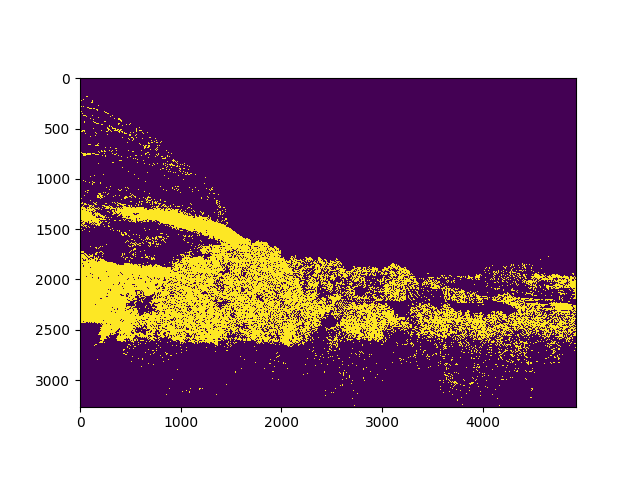

In [25]:
fig,ax = subplots()
ax.imshow(mask_d.get())


In [83]:
from scipy.stats import linregress
linregress(c0, c1)

LinregressResult(slope=1.0544769064059347, intercept=0.2007971644761355, rvalue=0.9764060395878557, pvalue=0.0, stderr=5.814799274251895e-05)

# Measurement of the flickering

In [26]:
default = (1,0,1,0,0)
delta_L = {images[0]: default}
results = [default]
current = images[0]
srgb0_d.set(numpy.asarray(Image.open(current)))
e1 = sRGB_to_Lab(queue, (shape[1], shape[0]), None, 
                   srgb0_d.data, lab0_d.data, 
                   numpy.int32(shape[1]), numpy.int32(shape[0]))

for img in images[1:]:
    srgb1_d.set(numpy.asarray(Image.open(img)))
    e2 = sRGB_to_Lab(queue, (shape[1], shape[0]), None, 
                   srgb1_d.data, lab1_d.data, 
                   numpy.int32(shape[1]), numpy.int32(shape[0]))
    m = sigma_clip_cl(lab0_d, lab1_d)
    print(os.path.basename(img), m)
    results.append(m)
    delta_L[img]=m

    srgb0_d, srgb1_d = srgb1_d, srgb0_d
    lab0_d, lab1_d = lab1_d, lab0_d


2018-06-26-19h25m44-NIKON_D5100.jpg (1.0016025, -0.08101654, 0.020909423, 0.37863737028225225, array(11391401., dtype=float32))
2018-06-26-19h26m29-NIKON_D5100.jpg (0.9992806, -0.078453064, 0.021127954, 0.3698855387574991, array(11552596., dtype=float32))
2018-06-26-19h27m14-NIKON_D5100.jpg (1.0034202, -0.03989029, 0.021082608, 0.3736116529006817, array(11484067., dtype=float32))
2018-06-26-19h27m59-NIKON_D5100.jpg (0.9974836, -0.12376404, 0.020960147, 0.3664317544231485, array(11286593., dtype=float32))
2018-06-26-19h28m44-NIKON_D5100.jpg (1.0012013, -0.063583374, 0.021174198, 0.34254271379796897, array(11305925., dtype=float32))
2018-06-26-19h29m29-NIKON_D5100.jpg (1.0074983, 0.060829163, 0.02136099, 0.37382131665598395, array(11593833., dtype=float32))
2018-06-26-19h30m14-NIKON_D5100.jpg (0.99838746, -0.023658752, 0.02095732, 0.3676891683415075, array(11326358., dtype=float32))
2018-06-26-19h30m59-NIKON_D5100.jpg (1.0046436, 0.05989456, 0.020783579, 0.403322582667116, array(11391177

2018-06-26-20h14m29-NIKON_D5100.jpg (1.1113478, 3.1717377, 0.020541314, 2.6243628541117854, array(13559781., dtype=float32))
2018-06-26-20h15m14-NIKON_D5100.jpg (1.004117, 0.20962524, 0.018729493, 0.49981009181835695, array(12597955., dtype=float32))
2018-06-26-20h15m59-NIKON_D5100.jpg (1.0001655, 0.035728455, 0.019393895, 0.4717128534277768, array(13247645., dtype=float32))
2018-06-26-20h16m44-NIKON_D5100.jpg (1.001795, 0.10473633, 0.019273961, 0.481931814102417, array(13826348., dtype=float32))
2018-06-26-20h17m29-NIKON_D5100.jpg (0.9993189, 0.027378082, 0.019697398, 0.4764035678614989, array(13612888., dtype=float32))
2018-06-26-20h18m14-NIKON_D5100.jpg (0.98249865, -0.62324905, 0.019765755, 0.7501338260284875, array(13423572., dtype=float32))
2018-06-26-20h18m59-NIKON_D5100.jpg (1.007382, 0.47478867, 0.01929733, 0.6214171370669646, array(13280533., dtype=float32))
2018-06-26-20h19m44-NIKON_D5100.jpg (0.9757127, -1.1315193, 0.019513777, 0.971127535419796, array(13980984., dtype=floa

2018-06-26-21h03m14-NIKON_D5100.jpg (1.0008284, -0.058753967, 0.019536693, 0.4061623961626559, array(13913070., dtype=float32))
2018-06-26-21h03m59-NIKON_D5100.jpg (1.002034, 0.068408966, 0.019636566, 0.43279929843045334, array(14034887., dtype=float32))
2018-06-26-21h04m44-NIKON_D5100.jpg (0.997074, -0.3493271, 0.020150999, 0.4987936165188336, array(14395674., dtype=float32))
2018-06-26-21h05m29-NIKON_D5100.jpg (1.0048829, 0.32268143, 0.020296546, 0.5099810820356916, array(14554293., dtype=float32))
2018-06-26-21h06m14-NIKON_D5100.jpg (0.9952668, -0.32692337, 0.020185558, 0.5082568141081827, array(14341222., dtype=float32))
2018-06-26-21h06m59-NIKON_D5100.jpg (1.0051821, 0.37002182, 0.020355925, 0.5177098387903438, array(14644776., dtype=float32))
2018-06-26-21h07m44-NIKON_D5100.jpg (1.0009689, -0.10115814, 0.019569702, 0.3979977445949066, array(13841143., dtype=float32))
2018-06-26-21h08m29-NIKON_D5100.jpg (1.0013092, -0.10568619, 0.01953736, 0.40332452721743267, array(13812132., dty

2018-06-26-21h51m59-NIKON_D5100.jpg (0.99701923, 0.14599991, 0.020773774, 0.46871721957539664, array(14515365., dtype=float32))
2018-06-26-21h52m44-NIKON_D5100.jpg (1.000007, 0.372509, 0.020953793, 0.5092710852225859, array(14830122., dtype=float32))
2018-06-26-21h53m29-NIKON_D5100.jpg (0.9897566, -0.2923813, 0.020839727, 0.47353379674045065, array(14601696., dtype=float32))
2018-06-26-21h54m14-NIKON_D5100.jpg (0.9931602, -0.06567001, 0.02110937, 0.4707228982720554, array(14609764., dtype=float32))
2018-06-26-21h54m59-NIKON_D5100.jpg (0.98480743, -0.46984863, 0.021453517, 0.49388254692074346, array(14589034., dtype=float32))
2018-06-26-21h55m44-NIKON_D5100.jpg (0.9973265, 0.117183685, 0.021737698, 0.4715970925998399, array(14586295., dtype=float32))
2018-06-26-21h56m29-NIKON_D5100.jpg (0.9884195, -0.24942017, 0.02199282, 0.4680308324082281, array(14656316., dtype=float32))
2018-06-26-21h57m14-NIKON_D5100.jpg (0.98477316, -0.40756607, 0.022557693, 0.482245410485431, array(14728191., dty

2018-06-26-22h40m44-NIKON_D5100.jpg (0.9790068, -0.11297989, 0.058934975, 0.4662494328954418, array(14978315., dtype=float32))
2018-06-26-22h41m29-NIKON_D5100.jpg (0.9631831, -0.16952038, 0.06161956, 0.46833990886126786, array(14940606., dtype=float32))
2018-06-26-22h42m14-NIKON_D5100.jpg (1.0334915, 0.21816063, 0.06083465, 0.41090421890462236, array(14987941., dtype=float32))
2018-06-26-22h42m59-NIKON_D5100.jpg (0.93644077, -0.33173084, 0.063861005, 0.5523074383676594, array(15273820., dtype=float32))
2018-06-26-22h43m44-NIKON_D5100.jpg (1.0348928, 0.22472, 0.06317867, 0.4091016386431737, array(14862468., dtype=float32))
2018-06-26-22h44m29-NIKON_D5100.jpg (0.77431434, -0.5549545, 0.08487571, 0.6298055369166472, array(14534713., dtype=float32))
2018-06-26-22h45m14-NIKON_D5100.jpg (0.95195097, -0.1439209, 0.08696789, 0.4472800738751812, array(15156948., dtype=float32))
2018-06-26-22h45m59-NIKON_D5100.jpg (1.2636539, 0.9141817, 0.08258787, 0.9325023508885326, array(15008278., dtype=floa

2018-06-26-23h30m14-NIKON_D5100.jpg (0.9636651, -0.1550026, 0.097249724, 0.36397159129883105, array(14806393., dtype=float32))
2018-06-26-23h30m59-NIKON_D5100.jpg (1.137308, 0.61587715, 0.09402343, 0.6867288893955585, array(15217617., dtype=float32))
2018-06-26-23h31m44-NIKON_D5100.jpg (0.92660767, -0.30857754, 0.08951498, 0.46611936014700667, array(15009545., dtype=float32))
2018-06-26-23h32m29-NIKON_D5100.jpg (0.9640034, -0.18521881, 0.095521465, 0.35947823832271547, array(14938385., dtype=float32))
2018-06-26-23h33m14-NIKON_D5100.jpg (0.9580982, -0.14622688, 0.10129841, 0.3583981077207596, array(14885757., dtype=float32))
2018-06-26-23h33m59-NIKON_D5100.jpg (1.0015763, 0.0048179626, 0.098682016, 0.32755327310230764, array(14847279., dtype=float32))
2018-06-26-23h34m44-NIKON_D5100.jpg (1.0381681, 0.17168903, 0.10040381, 0.37442563429529535, array(15018638., dtype=float32))
2018-06-26-23h35m29-NIKON_D5100.jpg (0.9579633, -0.14785004, 0.10124225, 0.3497297701147671, array(15055897., dt

2018-06-27-00h18m59-NIKON_D5100.jpg (0.902135, -0.33950615, 0.10526776, 0.42299243617772675, array(15271801., dtype=float32))
2018-06-27-00h19m44-NIKON_D5100.jpg (1.0020995, 0.010540009, 0.10611931, 0.28575901995223413, array(15182733., dtype=float32))
2018-06-27-00h20m29-NIKON_D5100.jpg (1.024259, 0.10270691, 0.10767257, 0.3092427951145959, array(15220068., dtype=float32))
2018-06-27-00h21m14-NIKON_D5100.jpg (1.0187489, 0.09138107, 0.10299302, 0.3180755380821106, array(15227323., dtype=float32))
2018-06-27-00h21m59-NIKON_D5100.jpg (0.91596913, -0.26232243, 0.11203542, 0.37267925617781367, array(15322060., dtype=float32))
2018-06-27-00h22m44-NIKON_D5100.jpg (1.0588745, 0.2397623, 0.11179519, 0.36809457331487283, array(15337829., dtype=float32))
2018-06-27-00h23m29-NIKON_D5100.jpg (1.1076076, 0.39924622, 0.10177471, 0.49148936381439406, array(15412373., dtype=float32))
2018-06-27-00h24m14-NIKON_D5100.jpg (0.94173527, -0.23403645, 0.09748047, 0.3644710415775507, array(15290598., dtype=fl

2018-06-27-01h08m29-NIKON_D5100.jpg (0.9961681, 0.0006980896, 0.10149387, 0.28438247867760563, array(15115010., dtype=float32))
2018-06-27-01h09m14-NIKON_D5100.jpg (0.9580553, -0.09520912, 0.107932664, 0.297922489549695, array(15171205., dtype=float32))
2018-06-27-01h09m59-NIKON_D5100.jpg (1.0443077, 0.10702419, 0.10768009, 0.31755636782913355, array(15183868., dtype=float32))
2018-06-27-01h10m44-NIKON_D5100.jpg (1.0017893, 0.0037546158, 0.1022317, 0.27813122352260444, array(15054696., dtype=float32))
2018-06-27-01h11m29-NIKON_D5100.jpg (0.9579665, -0.12578201, 0.10837776, 0.31326022975402606, array(15162619., dtype=float32))
2018-06-27-01h12m14-NIKON_D5100.jpg (0.97619146, -0.076262474, 0.1114364, 0.2838936705323624, array(15211535., dtype=float32))
2018-06-27-01h12m59-NIKON_D5100.jpg (1.0207481, 0.08104515, 0.110997334, 0.29539654012370176, array(15210430., dtype=float32))
2018-06-27-01h13m44-NIKON_D5100.jpg (0.95122063, -0.10920906, 0.11454815, 0.30876214977492866, array(15255530., 

2018-06-27-01h57m14-NIKON_D5100.jpg (1.0897458, 0.19237804, 0.1283358, 0.35357229473967067, array(15326230., dtype=float32))
2018-06-27-01h57m59-NIKON_D5100.jpg (0.9869683, -0.059617996, 0.118612595, 0.280731406161584, array(15265089., dtype=float32))
2018-06-27-01h58m44-NIKON_D5100.jpg (0.8667247, -0.22608614, 0.1390977, 0.3738301608647349, array(15323086., dtype=float32))
2018-06-27-01h59m29-NIKON_D5100.jpg (1.044018, 0.043910503, 0.14338483, 0.28011222514312256, array(15220447., dtype=float32))
2018-06-27-02h00m14-NIKON_D5100.jpg (1.0236009, 0.061841965, 0.13599353, 0.27115154323433466, array(15183665., dtype=float32))
2018-06-27-02h00m59-NIKON_D5100.jpg (1.0954025, 0.22827625, 0.1289547, 0.35653913445506025, array(15278960., dtype=float32))
2018-06-27-02h01m44-NIKON_D5100.jpg (1.0047083, 0.01940918, 0.113388225, 0.27629022372970474, array(15227935., dtype=float32))
2018-06-27-02h02m29-NIKON_D5100.jpg (1.0362593, 0.11092281, 0.11532977, 0.30108950368232085, array(15231242., dtype=fl

2018-06-27-02h45m59-NIKON_D5100.jpg (0.9987424, 0.00530529, 0.091872305, 0.2960741690264723, array(14958708., dtype=float32))
2018-06-27-02h46m44-NIKON_D5100.jpg (1.0050013, -0.11457825, 0.089151315, 0.3550239081874786, array(15028548., dtype=float32))
2018-06-27-02h47m29-NIKON_D5100.jpg (1.0034138, 0.015716553, 0.09193664, 0.28799232689940835, array(15076290., dtype=float32))
2018-06-27-02h48m14-NIKON_D5100.jpg (0.99302757, -0.02460289, 0.09196654, 0.2959380671104945, array(15164252., dtype=float32))
2018-06-27-02h48m59-NIKON_D5100.jpg (1.003954, 0.031926155, 0.0916686, 0.29560991297749795, array(15181631., dtype=float32))
2018-06-27-02h49m44-NIKON_D5100.jpg (0.99878716, -0.03478813, 0.09228213, 0.2879151272623723, array(15062508., dtype=float32))
2018-06-27-02h50m29-NIKON_D5100.jpg (0.9912194, -0.012089729, 0.0927828, 0.30251272490801306, array(15173891., dtype=float32))
2018-06-27-02h51m14-NIKON_D5100.jpg (1.0027723, -0.008769035, 0.09395937, 0.28365365416365007, array(14985553., dt

2018-06-27-03h34m44-NIKON_D5100.jpg (0.9938124, -0.024603844, 0.10594778, 0.27178136288445737, array(15099076., dtype=float32))
2018-06-27-03h35m29-NIKON_D5100.jpg (1.0018601, 0.017168045, 0.10650009, 0.266035188487144, array(15016882., dtype=float32))
2018-06-27-03h36m14-NIKON_D5100.jpg (0.99026805, -0.01624775, 0.108115844, 0.27487570652278775, array(15085988., dtype=float32))
2018-06-27-03h36m59-NIKON_D5100.jpg (0.99682045, -0.0024900436, 0.10778921, 0.25895362083737333, array(15050273., dtype=float32))
2018-06-27-03h37m44-NIKON_D5100.jpg (1.0017842, 0.022197723, 0.10759652, 0.2704154721027193, array(14845568., dtype=float32))
2018-06-27-03h38m29-NIKON_D5100.jpg (0.99350244, -0.01597023, 0.107457146, 0.2668864604018686, array(15115474., dtype=float32))
2018-06-27-03h39m14-NIKON_D5100.jpg (0.9923811, -0.012324333, 0.10900616, 0.264957521250972, array(15097583., dtype=float32))
2018-06-27-03h39m59-NIKON_D5100.jpg (1.0001734, 0.0018205643, 0.10951534, 0.2503492923740529, array(15002732

2018-06-27-04h23m29-NIKON_D5100.jpg (0.99864346, 0.01525116, 0.11822885, 0.23654721607251364, array(15145032., dtype=float32))
2018-06-27-04h24m14-NIKON_D5100.jpg (1.0144448, 0.052056313, 0.12079533, 0.27226597217626863, array(15267430., dtype=float32))
2018-06-27-04h24m59-NIKON_D5100.jpg (1.0021923, 0.034285545, 0.11436427, 0.2516747654807778, array(15287362., dtype=float32))
2018-06-27-04h25m44-NIKON_D5100.jpg (1.0045394, 0.04693508, 0.11266884, 0.28542579307951743, array(15413754., dtype=float32))
2018-06-27-04h26m29-NIKON_D5100.jpg (1.0039957, 0.03218651, 0.11447958, 0.2499804891362539, array(15190850., dtype=float32))
2018-06-27-04h27m14-NIKON_D5100.jpg (1.008296, 0.053153038, 0.11385919, 0.27845524369887026, array(15277148., dtype=float32))
2018-06-27-04h27m59-NIKON_D5100.jpg (1.0097992, 0.042201042, 0.11328648, 0.28284945049603716, array(15259814., dtype=float32))
2018-06-27-04h28m44-NIKON_D5100.jpg (1.0113968, 0.03199482, 0.111663856, 0.27747327291184964, array(15282975., dtype

2018-06-27-05h12m59-NIKON_D5100.jpg (0.99972254, -0.049922943, 0.02699979, 0.42349259036584613, array(14640523., dtype=float32))
2018-06-27-05h13m44-NIKON_D5100.jpg (0.99834174, -0.1650238, 0.027753761, 0.450324580919356, array(15122226., dtype=float32))
2018-06-27-05h14m29-NIKON_D5100.jpg (1.0026957, 0.056552887, 0.027161831, 0.3985077715655745, array(14657324., dtype=float32))
2018-06-27-05h15m14-NIKON_D5100.jpg (1.0069134, 0.0423851, 0.026990235, 0.41922902791019845, array(14696716., dtype=float32))
2018-06-27-05h15m59-NIKON_D5100.jpg (1.0200381, 0.29378128, 0.026831746, 0.48692312981107183, array(14950762., dtype=float32))
2018-06-27-05h16m44-NIKON_D5100.jpg (1.0247048, 0.49421692, 0.02652438, 0.5366451007563323, array(15442222., dtype=float32))
2018-06-27-05h17m29-NIKON_D5100.jpg (1.0067046, 0.07629013, 0.025757067, 0.4136042479565048, array(15271362., dtype=float32))
2018-06-27-05h18m14-NIKON_D5100.jpg (1.0181642, 0.31182098, 0.025207005, 0.5007644388912672, array(15233199., dtyp

2018-06-27-06h01m44-NIKON_D5100.jpg (1.0020273, 0.27340317, 0.019623337, 0.46115738066997786, array(14660155., dtype=float32))
2018-06-27-06h02m29-NIKON_D5100.jpg (0.99806744, -0.22877884, 0.019747606, 0.47407023295365885, array(14866993., dtype=float32))
2018-06-27-06h03m14-NIKON_D5100.jpg (1.0010489, 0.20423889, 0.019591136, 0.4428305115134233, array(14620069., dtype=float32))
2018-06-27-06h03m59-NIKON_D5100.jpg (1.0011934, 0.19883728, 0.019740477, 0.44860845905745106, array(14926341., dtype=float32))
2018-06-27-06h04m44-NIKON_D5100.jpg (0.99767035, -0.3089714, 0.019920817, 0.4935852795234799, array(15181050., dtype=float32))
2018-06-27-06h05m29-NIKON_D5100.jpg (1.0018699, 0.27264786, 0.019895053, 0.4690849427730757, array(15092102., dtype=float32))
2018-06-27-06h06m14-NIKON_D5100.jpg (1.0000062, 0.050628662, 0.01954753, 0.3945112258405049, array(14770753., dtype=float32))
2018-06-27-06h06m59-NIKON_D5100.jpg (1.0009459, 0.1507492, 0.019756394, 0.44344405491139177, array(15091010., dt

2018-06-27-06h50m29-NIKON_D5100.jpg (1.0006319, 0.13465881, 0.019051578, 0.43187233329079894, array(15227176., dtype=float32))
2018-06-27-06h51m14-NIKON_D5100.jpg (0.99970055, -0.0011062622, 0.018815143, 0.38646125306205564, array(14957624., dtype=float32))
2018-06-27-06h51m59-NIKON_D5100.jpg (1.0003822, 0.23254776, 0.019013274, 0.4511325394283648, array(15273801., dtype=float32))
2018-06-27-06h52m44-NIKON_D5100.jpg (0.99881625, -0.42915726, 0.019268889, 0.5088662688465364, array(15571760., dtype=float32))
2018-06-27-06h53m29-NIKON_D5100.jpg (1.0002216, 0.2630005, 0.019172428, 0.44443951851965136, array(15386369., dtype=float32))
2018-06-27-06h54m14-NIKON_D5100.jpg (0.99994814, 0.06612015, 0.018848434, 0.3919109395675202, array(15039533., dtype=float32))
2018-06-27-06h54m59-NIKON_D5100.jpg (0.999171, -0.36551666, 0.01921828, 0.48609160058164286, array(15446479., dtype=float32))
2018-06-27-06h55m44-NIKON_D5100.jpg (1.0003275, 0.117866516, 0.019076696, 0.42680801220643266, array(15196397

2018-06-27-07h39m14-NIKON_D5100.jpg (1.000666, 0.35803604, 0.018969242, 0.4883531838188349, array(15351116., dtype=float32))
2018-06-27-07h39m59-NIKON_D5100.jpg (0.9991595, -0.26515198, 0.018836824, 0.4642921655855344, array(15200428., dtype=float32))
2018-06-27-07h40m44-NIKON_D5100.jpg (0.9999928, 0.014072418, 0.018619532, 0.37898250899198554, array(14850272., dtype=float32))
2018-06-27-07h41m29-NIKON_D5100.jpg (0.99953383, 0.026836395, 0.018688418, 0.38548845963003536, array(14943796., dtype=float32))
2018-06-27-07h42m14-NIKON_D5100.jpg (0.9999884, 0.052383423, 0.018703148, 0.3919698610573186, array(14968335., dtype=float32))
2018-06-27-07h42m59-NIKON_D5100.jpg (1.0000496, -0.043945312, 0.018691957, 0.3838485070198776, array(14963670., dtype=float32))
2018-06-27-07h43m44-NIKON_D5100.jpg (0.9999385, 0.14035416, 0.01889313, 0.4239159897827711, array(15263576., dtype=float32))
2018-06-27-07h44m29-NIKON_D5100.jpg (1.0004994, 0.06523895, 0.018782387, 0.4052737725016031, array(15188738., d

5916520.129152377


<IPython.core.display.Javascript object>


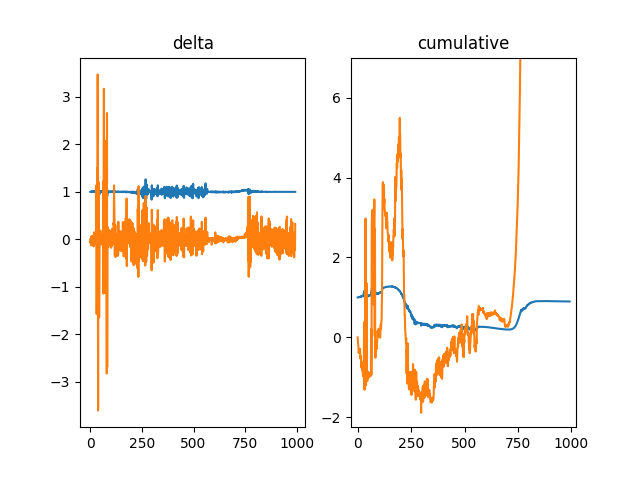

Text(0.5,1,'cumulative')

In [30]:
print(numpy.std(results))
fig,ax = subplots(1,2)
ax[0].plot([i[0] for i in results], label="raw slope")
ax[0].plot([i[1] for i in results], label="raw intercept")

cumul = []
cur = (1,0)
for res in results:
    cur = (cur[0]*res[0], res[1] + res[0]*cur[1])
    cumul.append(cur)
# cs = numpy.cumsum(results)
# from scipy.ndimage import gaussian_filter1d
# smooth = gaussian_filter1d(cs, 15)
ax[1].plot([i[0] for i in cumul], label="measured slope")
ax[1].plot([i[1] for i in cumul], label="measured intercept")
# ax[1].plot(smooth,label="smoothed")
# ax[0].plot(cs-smooth, label="delta_smooth")
# ax[0].legend()
ax[0].set_title("delta")
ax[1].set_title("cumulative")

<IPython.core.display.Javascript object>


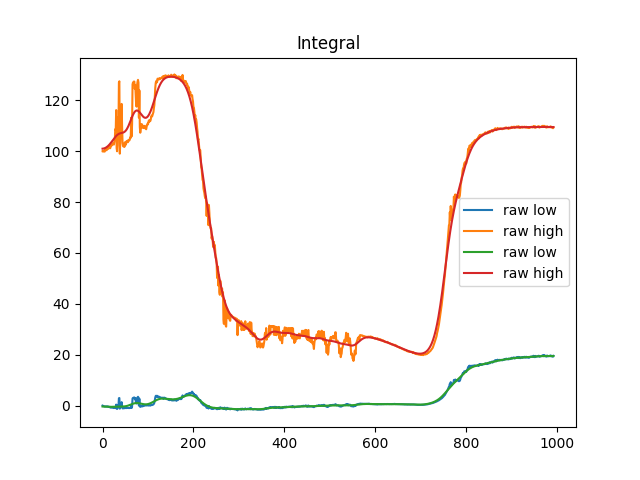

In [39]:
from scipy.ndimage.filters import gaussian_filter1d
sigma = 12

fig,ax = subplots(1,1)
raw_low = [i[1] for i in cumul]
raw_high = [i[0]*100+i[1] for i in cumul]
ax.plot(raw_low, label="raw low")
ax.plot(raw_high, label="raw high")

smooth_low = gaussian_filter1d(raw_low, sigma)
smooth_high = gaussian_filter1d(raw_high, sigma)
ax.plot(smooth_low, label="raw low")
ax.plot(smooth_high, label="raw high")


ax.set_title("Integral")
ax.legend()


<IPython.core.display.Javascript object>


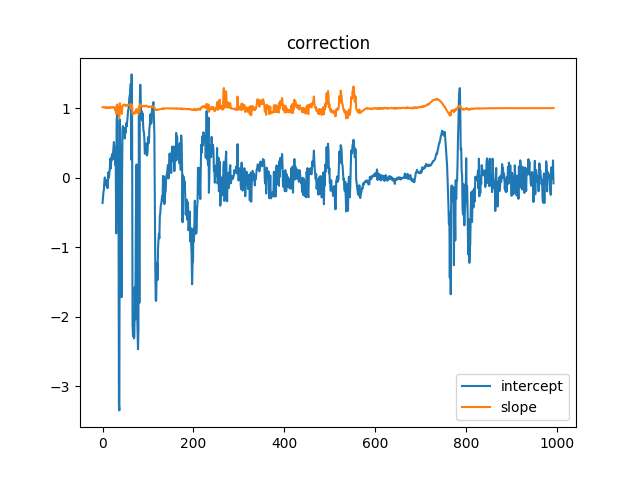

In [44]:
correct_intercept =  smooth_low - raw_low
correct_slope =  (smooth_high-smooth_low)/(numpy.asarray(raw_high)-raw_low)
fig,ax = subplots(1,1)
ax.plot(correct_intercept, label="intercept")
ax.plot(correct_slope, label="slope")


ax.set_title("correction")
ax.legend()


# Corrections 

In [45]:
target = os.path.join(source, "deflickv2_scaled")
if not os.path.isdir(target):
    os.makedirs(target)

In [47]:
%time
HD = (1080, 1920, 3)
srgb_HD_d = gpuarray.empty(queue, HD, "uint8")
lab_HD_d = gpuarray.empty(queue, HD, "float32")
for img, cor0, cor1, offset_y in zip(images, correct_intercept, correct_slope, linspace(492,0,len(images))):
    srgb1_d.set(numpy.asarray(Image.open(img)))
    e1 = sRGB_to_Lab(queue, (shape[1], shape[0]), None, 
                   srgb1_d.data, lab1_d.data, 
                   numpy.int32(shape[1]), numpy.int32(shape[0]))
    e2 = offset_LAB(queue, (shape[1], shape[0]), None, 
                   lab1_d.data, numpy.float32(cor0), numpy.float32(cor1),
                   numpy.int32(shape[1]), numpy.int32(shape[0]))
    e4 = decimate(queue, (HD[1], HD[0]), None,
                  lab1_d.data, lab_HD_d.data,
                  numpy.int32(shape[1]), numpy.int32(shape[0]),
                  numpy.int32(HD[1]), numpy.int32(HD[0]),
                  numpy.float32(0), numpy.float32(offset_y),
                  numpy.float32(2.566666666666667), numpy.float32(2.566666666666667),
                  numpy.int32(3),numpy.int32(0),
                 )
    e3 = Lab_to_sRGB(queue, (HD[1], HD[0]), None, 
                     lab_HD_d.data, srgb_HD_d.data, 
                     numpy.int32(HD[1]), numpy.int32(HD[0]))
    Image.fromarray(srgb_HD_d.get()).save(os.path.join(target, os.path.basename(img)))